In [47]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [48]:
from fastai.text import *

In [103]:
import fastai
print(fastai.__version__)

1.0.55


# Content

- The solution uses the fastai library for training the model. 
- We train on the full dataset and limit ourselves to positive (3,4,5 stars) / negative (1,2 stars) rating.
- The final model achieves an **accuracy of 95%** on the held out test set (20% of the data).

The task analysis consists of the following parts:

1. **Data Preprocessing**
   - in which the data is read from a file into a pandas dataframe and missing values are removed
2. **Data Exploration**
   - where we explore some statistics of the dataset such as:
     - how many users/products there are
     - how many reviews per product/user there are
     - distribution of reviews by year
     - etc.
3. **Language Model**
    - where we train a language model using transfer learning. We fine-tune a model trained on a subset of English Wikipedia
    using the reviews in our dataset
4. **Sentiment Classifier**
    - we train a classifier discerning between positive (3, 4, 5 star reviews) / negative (1, 2 stars) classes
4. **Conclusion**
    - where we evaluate the results and suggest further improvements

# Data Preprocessing

## Read the data into a dataframe

In [49]:
data_path = Config.data_path()/'amazon-fine-foods'; data_path.mkdir(parents=True, exist_ok=True)

In [25]:
txt_file = data_path/'finefoods.txt'

In [26]:
n_reviews = !grep -o 'product/productId:' {txt_file} | wc -l
n_reviews = int(n_reviews[0]); n_reviews

568454

In [126]:
feature_columns = ['product/productId', 'review/userId', 'review/profileName',
                   'review/helpfulness', 'review/score', 'review/time', 'review/summary', 'review/text']

In [127]:
df = pd.DataFrame(index=range(n_reviews), columns=feature_columns)

In [129]:
with open(txt_file, 'r', encoding='latin-1') as f:
    # Remove the last element (would be empty since there is a trailing double newline at the end of file)
    reviews = f.read().split('\n\n')[:-1]

In [130]:
reviews = [r.split('\n') for r in reviews]

### Cleanup
Certain reviews contained an extra line just after the profile name. This messed up creating the dataframe so we delete them.

In [131]:
for l in reviews[94197]: print(l)

product/productId: B002RIZUQ2
review/userId: AS2DLXUWDK0GP
review/profileName: MABEL "Tell us about yourself!
88 years old. ...
review/helpfulness: 1/1
review/score: 4.0
review/time: 1289088000
review/summary: delicious
review/text: if you prefer a tasteful and less strong flavored coffee, I reommend Green Mountain's hazelnut.  I have not been a coffee drinker, but upon tasting this brew, I drink it daily.


In [132]:
for i in range(len(reviews)):
    if len(reviews[i]) != len(feature_columns):
        del reviews[i][3]

### Create the dataframe.

In [ ]:
%%time
regex = re.compile(r"^([^:]*): (.*)$") # omits the category prefix and catpures the value such as 'product/productId: B002RIZUQ2'
for i, review in enumerate(reviews):
    for line in review:
        column, data = regex.match(line).groups()
        assert (column in feature_columns) # sanity check
        df.iloc[i][column] = data
    if i % 100000 == 0: print(i)

In [ ]:
df.to_csv(data_path/'finefoods.csv', index=False)

In [51]:
df = pd.read_csv(data_path/'finefoods.csv')

### Remove entries with missing values
There are only a few of them so we can omit them without worrying too much about this.

In [52]:
nans = df[df.isnull().any(axis=1)]; nans.head()

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
25509,B000LKZB4Y,A36BVYD0NT7Z0F,NaN,0/0,5.0,1314576000,These are the best mints and no aspartame or BHT,I was so shocked to find out that almost all g...
33958,B00412W76S,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1/24,2.0,1173312000,NaN,I only used two maybe three tea bags and got p...
38874,B000AYDGZ2,A36BVYD0NT7Z0F,NaN,2/3,1.0,1278374400,doesn't anyone care that they are putting BHT ...,I called Kellogg's to see why Special K red be...
40548,B00020HHRW,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1/24,2.0,1173312000,NaN,I only used two maybe three tea bags and got p...
49800,B000CRHQN0,A2LYFY32LXQDON,NaN,0/0,2.0,1282608000,They were melted and the chocolate had turned ...,We love these bars but i won't order them ship...


In [53]:
print(df.shape)
print(nans.shape)

(568454, 8)
(43, 8)


In [54]:
df = df.drop(list(nans.index.values));

In [55]:
df.shape

(568411, 8)

### Create new columns
Create two new columns:
 - one **concatenating the summary and text** since the two are both useful for sentiment analysis (this will be the independent variable for training)
 - the **sentiment of the review** (the dependent variable/label) which can be 'positive'/'negative'

In [56]:
separator = ' '
df["review/summary_and_text"] = df["review/summary"].map(str) + separator + df["review/text"]
df['label'] = df.apply(lambda row: 'positive' if row['review/score'] > 2.0 else 'negative', axis=1) 

In [57]:
df.sort_values(by=['review/userId'], inplace=True);
df.reset_index(drop=True, inplace=True)

In [58]:
df.head()

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/summary_and_text,label
0,B006Q820X0,#oc-R103C0QSV1DF5E,C,1/2,5.0,1343088000,Great for the Price,I have to say I was a little apprehensive to b...,Great for the Price I have to say I was a litt...,positive
1,B008I1XPKA,#oc-R109MU5OBBZ59U,AayGee,0/1,5.0,1350086400,AWESOME Coffee!!!!,Received my free K cups as a sample promotion ...,AWESOME Coffee!!!! Received my free K cups as ...,positive
2,B008I1XPKA,#oc-R10LFEMQEW6QGZ,Julie,0/1,5.0,1345939200,Brooklyn Bean Roastery Breakfast Blend K-Cups,Brooklyn Bean Roastery Blend K-Cups are great ...,Brooklyn Bean Roastery Breakfast Blend K-Cups ...,positive
3,B0026LJ3EA,#oc-R10LT57ZGIB140,dipr,0/0,3.0,1310601600,Some damage,The shipment of the dog food was quick. Howev...,Some damage The shipment of the dog food was q...,positive
4,B006Q820X0,#oc-R10UA029WVWIUI,Kim D,0/0,1.0,1342483200,Less than satisfactory. I gave the Brooklyn K...,"Brooklyn ""French Roast"" K-Cup Coffee is not on...",Less than satisfactory. I gave the Brooklyn K...,negative


# Data Exploration

In [149]:
''' A helper function creating multiple histogram plots with different ranges of values.'''
def ranged_multi_histogram(data, title, xlabel, ylabel, ranges, bins=50, figsize=(20,8)):
    rows = len(ranges) // 2
    fig, axes = plt.subplots(rows, 2, figsize=figsize)
    plt.suptitle(title, fontsize=16)
    for idx, ax in enumerate(axes.flat):
        ax.hist(data, bins=50, range=ranges[idx])
        ax.set_ylabel(xlabel, fontsize=16)
        ax.set_xlabel(ylabel, fontsize=16)

#### **Unique products in the dataset**

In [15]:
len(df['product/productId'].unique())

74258

#### **Unique users**

In [18]:
len(df['review/userId'].unique())

256047

#### **Review scores**

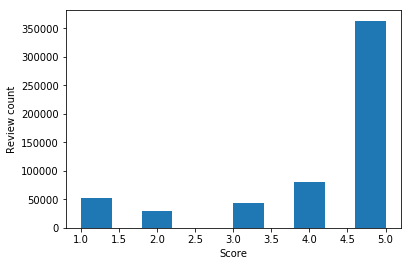

In [26]:
plt.hist(df['review/score']);
plt.xlabel('Score');
plt.ylabel('Review count');

Most reviews are positive - the dataset is unbalanced. It is also important to be aware that most people who write reviews are either very disappointed or very satisfied so there will likely be extremes of language in the text. This might be an issue when applying the model on more moderate reviews.

#### **Review word count**

In [143]:
review_word_counts = df.apply(lambda row: len(row['review/summary_and_text'].split(' ')), axis=1)

In [144]:
review_word_counts.min(), review_word_counts.max(), int(review_word_counts.mean())

(4, 3545, 86)

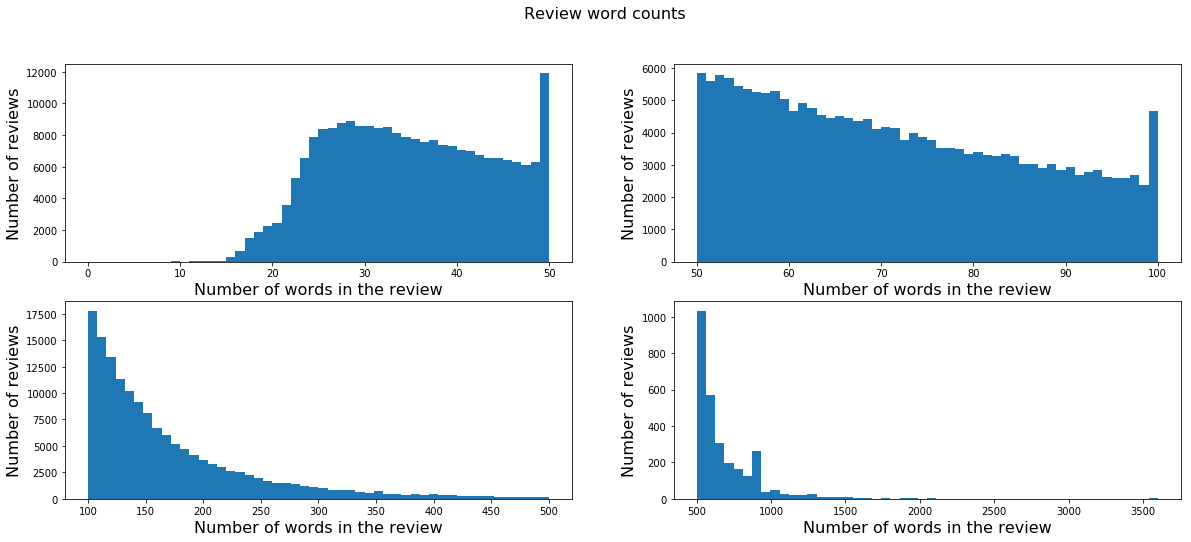

In [150]:
ranged_multi_histogram(review_word_counts, 'Review word counts', 'Number of reviews', 'Number of words in the review',
                       ranges=[(0, 50), (50, 100), (100, 500), (500, 3600)])

#### **Reviews per product**

In [152]:
product_review_counts = df['product/productId'].value_counts()
product_review_counts.min(), product_review_counts.max(), int(product_review_counts.mean())

(1, 913, 7)

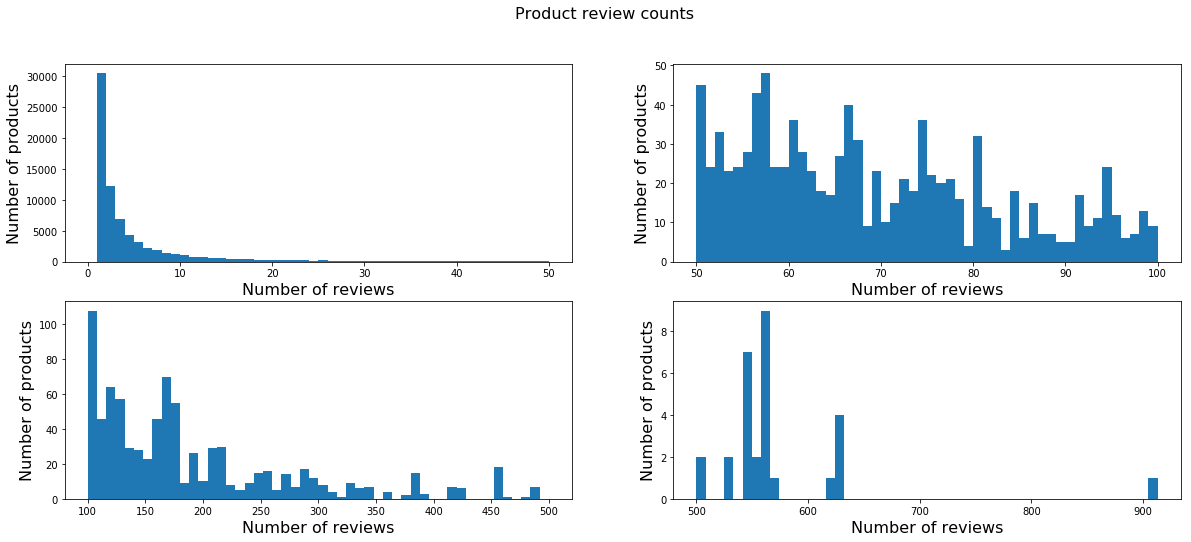

In [153]:
ranged_multi_histogram(product_review_counts, 'Product review counts', 'Number of products', 'Number of reviews',
                       ranges=[(0, 50), (50, 100), (100, 500), (500, 913)])

#### **Reviews per user**

In [154]:
user_review_counts = df['review/userId'].value_counts()
user_review_counts.min(), user_review_counts.max(), int(user_review_counts.mean())

(1, 448, 2)

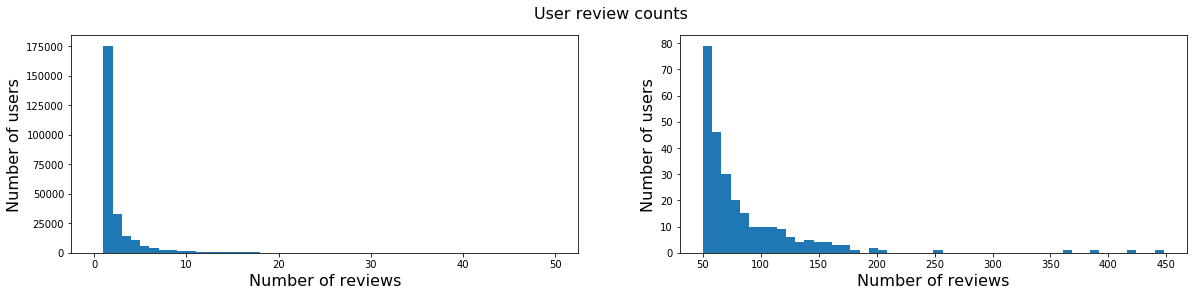

In [155]:
ranged_multi_histogram(user_review_counts, 'User review counts', 'Number of users', 'Number of reviews',
                       ranges=[(0, 50), (50, 448)], figsize=(20, 4))

#### **Reviews by year**

In [156]:
from datetime import datetime

In [157]:
review_times = df.apply(lambda row: datetime.utcfromtimestamp(row['review/time']), axis=1).to_frame('time')
review_times.sort_values(inplace=True, by='time')
review_years = review_times.apply(lambda row: row['time'].year, axis=1)

In [158]:
review_years.min(), review_years.max(), review_years.median()

(1999, 2012, 2011.0)

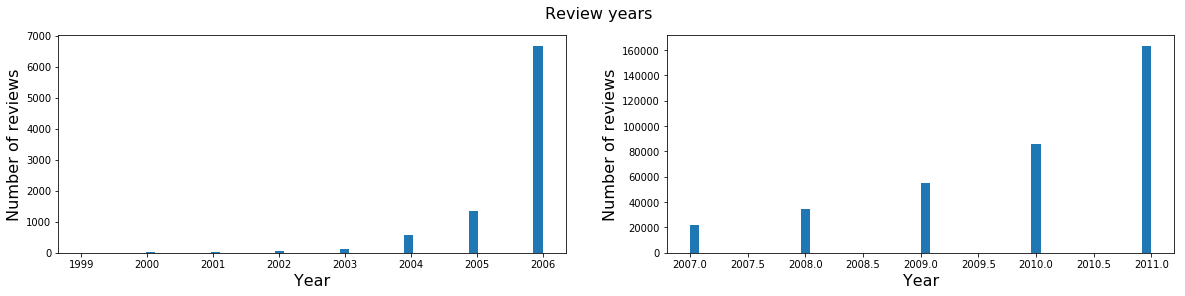

In [159]:
ranged_multi_histogram(review_years, 'Review years', 'Number of reviews', 'Year',
                       ranges=[(1999, 2006), (2007, 2011)], figsize=(20, 4))

Most reviews come from years 2008-2011. This might be relevant when using and evaluating our model. Although it is sensible to assume that the English vocabulary has not changed much for example between 1999 and 2011 and between 2011 and 2019 (if we were to deploy it on reviews written today), some new words might have entered the language that were not in usage then. 

But in our case this is just something to be aware of, the time span is not so large to make an important difference.

# Language Model
The language model is based on the AWD-LSTM architecture and is pretrained on the subset of English Wikipedia (the WikiText-103 corpus). We then fine-tune it on our corpus of over 500k reviews. Importantly we use the train, validation as well as test data for training the language model. This is fine, using the validation and test set for training would only be problematic if we made use of the labels.

The encoder part of the language model (which has understanding about how english language and specifically english language food reviews are formed) will be used as the basis of our sentiment classifier.

## Data

In [13]:
bs = 50

In [ ]:
data_lm = (TextList.from_df(df, cols='review/summary_and_text')
          .split_by_rand_pct(0.1, seed=42)
          .label_for_lm()
          .databunch(bs=bs))

In [280]:
data_lm.save('data_lm.pkl')

In [15]:
data_lm = load_data('.', 'data_lm.pkl', bs=bs)

In [16]:
data_lm.show_batch(3)

idx,text
0,"it . xxmaj overall , i was impressed . xxbos xxup awesome xxmaj coffee xxrep 4 ! xxmaj received my free k cups as a sample promotion and xxup love them . i have at least one a day at work xxrep 4 ! xxbos xxmaj some damage xxmaj the shipment of the dog food was quick . xxmaj however , when i opened the main box which contained several"
1,"xxmaj the best snack ! ! ! i always have these in our pantry ! xxmaj they are great when you want just something to nibble on , and also amazing in salads ! ! xxmaj the sea salt and garlic are without a doubt my favorite flavor of theirs . xxmaj do n't be hesitant about the garlic in them . xxmaj it 's really not strong at all"
2,have tried . xxmaj it is bold with a really nice finish . xxmaj not at all bitter like some of the decafs i have tried . xxbos xxmaj best xxmaj bold decaf xxmaj this is the best xxmaj decaf k - cup i have tried . xxmaj it is bold with a really nice finish . xxmaj not at all bitter like some of the decafs i have tried


## Train the model

In [17]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [288]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


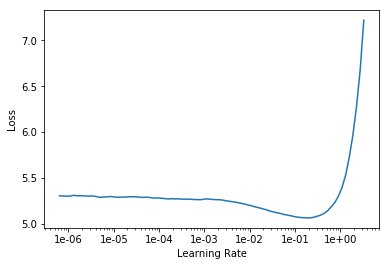

In [289]:
learn.recorder.plot()

In [292]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.724845,3.569823,0.315026,44:11


In [294]:
learn.save'lm-full-fit-head')

In [299]:
learn.load('lm-full-fit-head');

In [300]:
learn.fit_one_cycle(4, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.790637,3.724273,0.304310,50:16
1,3.794094,3.720109,0.305392,50:09
2,3.474240,3.403054,0.340417,50:05
3,3.310427,3.265811,0.357368,50:13


In [301]:
learn.save('lm-full-fit-head-2')

In [302]:
learn.unfreeze()

In [303]:
learn.fit_one_cycle(4, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.280616,3.239791,0.361205,50:09
1,3.257486,3.209735,0.365563,50:06
2,3.256770,3.178166,0.370407,50:08
3,3.229292,3.167437,0.372244,50:14


In [304]:
learn.save('lm-full-fine-tuned')

In [19]:
learn.load('lm-full-fine-tuned');

We can let the model hallucinate a product review for us.

In [25]:
TEXT = "I liked this "
N_WORDS = 100
N_SENTENCES = 1

In [26]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this  pasta The box was not as pictured , but it was not packaged in a box . i did not want to hear that item had the packing problem . But , i have no clue what happened . The cookies are a good quality product and would definitely recommend them . xxbos Great product , lousy service i love the flavor of this tea . i use it in my chai tea and it gives it a hint of sweetness . i love the fact that it 's organic and makes it easy to drink


We save the language model's encoder which creates and updates the hidden state. It will be used for creating the classifier.

In [24]:
learn.save_encoder('full-encoder')

# Sentiment Classifier
Predicts either a positive or a negative sentiment for the review.
## Data

### Splitting the data
We will divide the data into three splits (60/20/20 % of the data respectively):
 - train (the model uses this data to modify its parameters)
 - validation (we use this to assess the quality of the model during training and hyperparameter tuning)
 - test (this is the final evaluation of the model's performance and we should touch it as little as we can)
 
### Caveats for splitting the data:
- The reviews dataframe is now sorted by productId. When creating the splits we should make sure that reviews of the same product do not appear both in the train and either validation or test set. This will prevent the model from 'cheating' since reviews for the same product would likely be similar and the validation/test split are supposed to inform us about the model's generalization ability.
- The content of the review is also heavily correlated with the user who wrote it (the person probably has a very similar style of writing accross different reviews) so ideally, we would avoid leakage of both products and users between the train and test/validation splits. 
- For simplicity though, let's restrict us to avoiding leakage based on product.

In [59]:
bs = 50

In [60]:
n_reviews = df.shape[0]; n_reviews

568411

In [61]:
last_train_idx = int(n_reviews * 0.6)

In [62]:
last_valid_idx = last_train_idx + int(n_reviews * 0.2) + 1

The training and validation data for text classification consists of:
- **xs** (independent variable): **review text** (review summary and body)
- **ys** (dependent variable): **the label** (positive/negative sentiment of the review)
    
fastai is able to extract these from the provided data frame. We split the data into the train/validation splits using the indices we have generated.
We will use the data reserved for testing after finishing training for the model's final evaluation.

In [ ]:
data_clas = (TextList.from_df(df, cols='review/summary_and_text', vocab=data_lm.vocab)
             .split_by_idxs(train_idx=np.arange(last_train_idx), 
                            valid_idx=np.arange(last_train_idx, last_valid_idx))
             .label_from_df(cols='label')
             .databunch(bs=bs))

In [41]:
data_clas.save('data_clas.pkl')

In [63]:
data_clas = load_data('.', 'data_clas.pkl', bs=bs)

In [64]:
data_clas.show_batch()

text,target
"xxbos xxmaj an okay filtered municipal tap water with slight "" chalky "" aftertaste , but the misleading health claims and hype are quackery ! xxmaj fuzzy xxmaj wuzzy 's xxmaj summary : \n * * * xxmaj somewhat recommended , with reservations and only lukewarm fuzzies . \n \n xxmaj positives : \n \n + xxmaj not too expensive compared to other bottled water , although",positive
"xxbos xxmaj works as xxmaj advertised - xxmaj classy xxmaj product see update at end of review \n \n xxrep 18 * \n \n i was lamenting about only having frech lettuce , herbs , chives , and tomatoes from may garden during the long fall - winter - spring parts of the year . xxmaj the refrigerated stuff from the grocery store goes bad right away and",positive
"xxbos xxmaj yes , xxmaj virginia , was a very bad rabbit xxrep 4 . xxmaj when the mailman came , i ran excitedly out to meet him in the yard . xxmaj clad only in my fluffy lavendar slippers and a floral xxunk ... i am sure i was a ghastly sight ... but i just could nt wait one extra moment to finally get my hands on that",negative
"xxbos xxmaj high xxmaj promise , xxmaj less xxmaj delivery xxmaj high xxmaj promise , xxmaj less xxmaj delivery \n i started growing tomatoes with my aerogarden about two months ago . i got my first flower a few days ago , the first step towards tomatoes . xxmaj unfortunately , the pump on the device stopped working the next day . \n \n xxmaj the xxup faq",negative
"xxbos xxmaj kittties xxmaj liked at first , xxmaj then xxmaj turned xxmaj up xxmaj nose xxmaj when i initially ordered this xxmaj whiskas xxmaj perfectly xxmaj chicken for my cats , they liked it xxup ok . xxmaj they did not wolf it down , but they would eat it without complaint . \n \n xxup the xxup feline xxup eeding xxup scenario xxup at xxup my xxup",positive


## Train the model

We load the previously trained language model's encoder.

In [65]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('full-encoder')

In [44]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


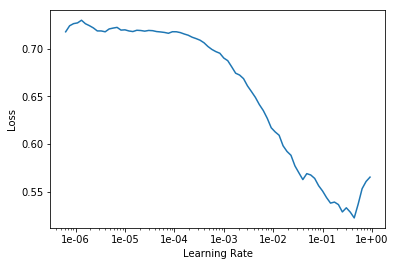

In [167]:
learn.recorder.plot()

In [66]:
learn.fit_one_cycle(3, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.228080,0.163478,0.931494,10:48
1,0.210666,0.149432,0.935030,11:35
2,0.201674,0.175998,0.935250,13:04


In [67]:
learn.save('full-classifier-1')

In [68]:
learn.load('full-classifier-1');

In [69]:
learn.freeze_to(-2)

In [70]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


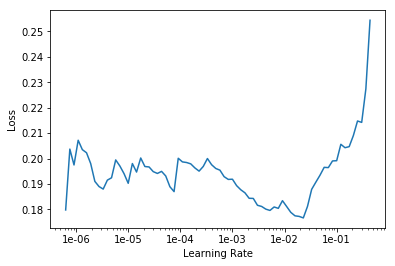

In [71]:
learn.recorder.plot()

In [72]:
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.152440,0.128459,0.947820,12:11
1,0.139513,0.120670,0.951074,12:25
2,0.140776,0.120183,0.951294,15:37


In [73]:
learn.save('full-classifier-2')

In [74]:
learn.load('full-classifier-2');

In [75]:
learn.freeze_to(-3)

In [76]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


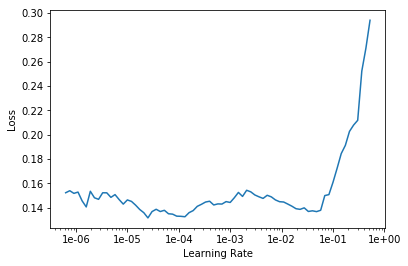

In [77]:
learn.recorder.plot()

In [78]:
learn.fit_one_cycle(3, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.133763,0.123140,0.951171,18:02
1,0.135237,0.123561,0.950432,17:34
2,0.124796,0.119778,0.951725,20:24


In [79]:
learn.save('full-classifier-3')

In [80]:
learn.load('full-classifier-3');

In [81]:
learn.unfreeze()

In [82]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


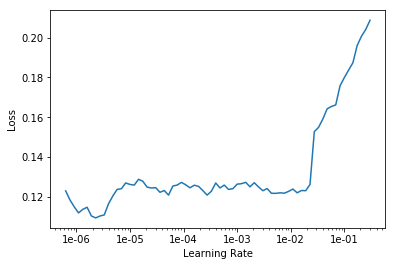

In [83]:
learn.recorder.plot()

In [84]:
learn.fit_one_cycle(3, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.139406,0.119188,0.951937,25:55
1,0.123554,0.115854,0.953344,27:34
2,0.115928,0.117962,0.953379,24:45


We could still continue training since accuracy keeps improving.

In [85]:
learn.save('full-classifier-final')

In [86]:
learn.load('full-classifier-final');

In [100]:
learn.show_results(rows=3)

text,target,prediction
"xxbos xxmaj works xxup great - you xxup have xxup to follow the instructions - read on xxmaj have had serious gopher problems for xxup years . xxmaj most effective up to this point have been ( for me ) the "" smoke bombs "" . those cost about $ 7 for 4 of them , and for them to be successful i needed to locate about 10 or so",positive,positive
"xxbos xxmaj constipation xxrep 5 ! xxmaj we breastfeed our month old boy , but since his xxunk level was still high , doctors recommended to switch to formula for 48 hours . xxmaj we started with xxmaj similac xxmaj advance ( xxmaj shield xxmaj plus ) which we still had from hospital . xxmaj first 24 hours were wonderful in terms of pooping , then we decided to switch",negative,positive
"xxbos xxmaj spookylicious xxmaj pop - xxmaj tarts : a xxmaj cautionary xxmaj tale . xxmaj spookylicious xxmaj pop - xxmaj tarts : a xxmaj cautionary xxmaj tale . \n \n xxmaj once upon a time , a long time ago in the far away land of last xxmaj october , a good wife and a bad husband bought xxmaj halloween xxmaj pop - xxmaj tarts and they were",positive,positive


### Try out some predictions.

In [135]:
learn.predict("What a terrible thing.")

(Category negative, tensor(0), tensor([0.9881, 0.0119]))

In [136]:
learn.predict("I really loved it.")

(Category positive, tensor(1), tensor([0.0017, 0.9983]))

## Evaluation on test data

Create a test set using the subset of the data that we reserved for this purpose and did not touch.

In [132]:
data_clas_test = (TextList.from_df(df, cols='review/summary_and_text', vocab=data_lm.vocab)
                  .split_by_idxs(train_idx=np.arange(1000), 
                                 valid_idx=np.arange(last_valid_idx, n_reviews))
                  .label_from_df(cols='label')
                  .databunch(bs=bs))

In [137]:
loss, acc = learn.validate(data_clas_test.valid_dl)

In [139]:
print(f'Test set accuracy is {acc}')

Test set accuracy is 0.9511268138885498


# Conclusion

### Suggestions for further improvement
- Retrain on all of the data (including test and validation) before final deployment
- Train the language model and classifier for longer since they were not overfitting yet
- Tune hyperparameters
- Fine-tune the language model on all Amazon reviews irrespective of the product category (not just for fine foods). It is very likely that a positive/negative review for an electronic appliance for example will contain very similar words as a review for food [available here](http://jmcauley.ucsd.edu/data/amazon/)
- Train a regression model classifying the sentiment in the range 1-5. I made a decision to label the ratings 3,4,5 as positive and 1,2 as negative but some users might consider a rating of 3 already to be a negative one
- Apply some forms of data augmentation to the text